In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm
from xgboost import XGBClassifier
from xgboost import plot_importance
# from sklearn import feature_selection
# from collections import Counter
# from imblearn.combine import SMOTEENN

In [2]:
def missing(df):
    """计算缺失值和缺失率

    Args:
        df (dataframe): 

    Returns:
        dataframe: 
    """
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([missing_number, missing_percent], axis=1, keys=['missing_number', 'missing_percent'])
    return missing_data

In [3]:
train = pd.read_excel('附件1语音业务用户满意度数据.xlsx')
test = pd.read_excel('附件3语音业务用户满意度预测数据.xlsx')

In [4]:
# 重复性校验
train.shape
train['用户id'].nunique() == train.shape[0]
train.duplicated().sum()
# missing(train)

0

In [5]:
set(train.columns.values)-set(test.columns.values)

{'ARPU（家庭宽带）',
 '前第3个月欠费金额',
 '家宽投诉',
 '当月欠费金额',
 '是否去过营业厅',
 '是否实名登记用户',
 '网络覆盖与信号强度',
 '语音方式',
 '语音通话整体满意度',
 '语音通话清晰度',
 '语音通话稳定性',
 '资费投诉',
 '重定向次数',
 '重定向驻留时长'}

In [6]:
set(test.columns.values)-set(train.columns.values)

{'性别', '是否不限量套餐到达用户', '是否投诉'}

In [7]:
# 按附件五说明处理缺失
train.是否关怀用户.fillna('否',inplace=True)
train.是否去过营业厅.fillna('否',inplace=True)
train.drop(['重定向次数','重定向驻留时长','其他，请注明','用户描述','其他，请注明.1','用户描述.1','用户id'],
            axis=1, inplace=True)
train.drop(train[train.是否5G网络客户.isnull()].index,axis=0,inplace=True)
train.外省流量占比.fillna(train.外省流量占比.median(),inplace=True)
train = train.reset_index(drop=True)

In [8]:
target = train.iloc[:,0:4]
train = train.iloc[:,4:]
test.drop(['用户id', '性别', '是否不限量套餐到达用户'],axis=1,inplace=True)

- 重编码（train）

In [9]:
reindex_col = [
       '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁', '手机没有信号', '有信号无法拨通',
       '通话过程中突然中断', '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见']
for col in reindex_col:
       train[col] = train[col].apply(lambda x: 0 if x==-1 else 1)
       
train['4\\5G用户'] = train['4\\5G用户'].apply(lambda x: 0 if x=='2G' else 1 if x=='4G' else 2)

train.loc[train[train['语音方式']=='VoLTE'].index, '语音方式']='VOLTE'

reindex_col=['是否关怀用户','是否4G网络客户（本地剔除物联网）', '是否5G网络客户','是否去过营业厅','是否实名登记用户']
for col in reindex_col:
    train[col] = train[col].apply(lambda x: 1 if x=='是' else 0 if x=='否' else x)

# 将终端品牌分为苹果，华为，小米和其他
name=['苹果','华为','小米科技']

train['终端品牌']=train['终端品牌'].apply(lambda x: '其他' if x not in name else x)
train.drop('终端品牌类型',axis=1, inplace=True)

# 查阅北京移动客户分级相关资料，客户星级重分类为（未评级准星一星二星）/（三星）/（银卡）/(金卡，白金卡，钻石卡)
def reindex(x):
    c1=['未评级','准星','一星','二星']
    c2=['三星']
    c3=['银卡']
    c4=['金卡','白金卡','钻石卡']
    if x in c1:
        x=1
    elif x in c2:
        x=2
    elif x in c3:
        x=3
    elif x in c4:
        x=4
    else:
        x
    return x

train['客户星级标识']=train['客户星级标识'].apply(reindex)

train.shape

(5428, 43)

- 重编码（test）

In [10]:
reindex_col = [
       '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁', '手机没有信号', '有信号无法拨通',
       '通话过程中突然中断', '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见']
for col in reindex_col:
       test[col] = test[col].apply(lambda x: 0 if x==-1 else 1)
       
test['4\\5G用户'] = test['4\\5G用户'].apply(lambda x: 0 if x=='2G' else 1 if x=='4G' else 2)

reindex_col=['是否关怀用户','是否4G网络客户（本地剔除物联网）', '是否5G网络客户']
for col in reindex_col:
    test[col] = test[col].apply(lambda x: 1 if x=='是' else 0 if x=='否' else x)

# 将终端品牌分为苹果，华为，小米和其他
name=['苹果','华为','小米科技']
test['终端品牌']=test['终端品牌'].apply(lambda x: '其他' if x not in name else x)
test.drop('终端品牌类型',axis=1, inplace=True)

# 查阅北京移动客户分级相关资料，客户星级重分类为（未评级准星一星二星）/（三星）/（银卡）/(金卡，白金卡，钻石卡)
def reindex(x):
    c1=['未评级','准星','一星','二星']
    c2=['三星']
    c3=['银卡']
    c4=['金卡','白金卡','钻石卡']
    if x in c1:
        x=1
    elif x in c2:
        x=2
    elif x in c3:
        x=3
    elif x in c4:
        x=4
    else:
        x
    return x

test['客户星级标识']=test['客户星级标识'].apply(reindex)

test.shape


(2599, 40)

- 异常值(train)

In [11]:
loss_times_cols = ['脱网次数','mos质差次数', '未接通掉话次数']
numcols = ['套外流量（MB）','套外流量费（元）', '外省语音占比', '外省流量占比','语音通话-时长（分钟）', '省际漫游-时长（分钟）',
'ARPU（家庭宽带）','当月ARPU', '当月MOU', '前3月ARPU', '前3月MOU',
'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）','当月欠费金额', '前第3个月欠费金额']

In [12]:
# fig=plt.figure(figsize=(20,10))
# for i in range(len(loss_times_cols)):
#     plt.subplot(1,3,i+1)
#     sns.boxplot(train[numcols[i]],orient='v',width=0.5)
#     plt.ylabel(loss_times_cols[i],fontsize=40)
# plt.show()

In [13]:
# fig=plt.figure(figsize=(80,60))
# for i in range(len(numcols)):
#     plt.subplot(4,4,i+1)
#     sns.boxplot(train[numcols[i]],orient='v',width=0.5)
#     plt.ylabel(numcols[i],fontsize=40)
# plt.show()

In [14]:
# fig=plt.figure(figsize=(80,60))
# for i in range(len(numcols)):
#     plt.subplot(4,4,i+1)
#     sns.histplot(train[numcols[i]])
#     plt.ylabel(numcols[i],fontsize=40)
# plt.show()

In [15]:
# 15个数值变量中大多数为0，存在异常值且差异极大，但是通话时长较长或者上网较多的用户，更能够从中发现问题，
# 考虑采用截尾方法处理，将大于$\mu+3\sigma$的数据标记为截尾,替换相应数值。
for i in numcols:
    mean_col=train[i].mean()
    std_col=train[i].std()
    train.loc[train[train[i]>mean_col+3*std_col].index,i]=mean_col+3*std_col

In [16]:
# # 数值变量标准化
# for i in numcols:
#     train[i] = preprocessing.StandardScaler().fit_transform(train[i].values.reshape(-1,1))

In [17]:
# # k均值聚类三个定量变量
# kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
# for col in numcols:
#     train[col] = kdis.fit_transform(train[col].values.reshape(-1,1))

In [18]:
# k均值聚类三个次数列
kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
for col in loss_times_cols:
    train[col] = kdis.fit_transform(train[col].values.reshape(-1,1))

In [19]:
# 独热编码语音方式和终端品牌
ohc_list = ['语音方式','终端品牌']
ohc = preprocessing.OneHotEncoder(drop='if_binary')
a = pd.DataFrame(ohc.fit_transform(train[ohc_list]).toarray(), columns=ohc.get_feature_names_out())
train = pd.concat([train, a], axis=1)
train = train.drop(ohc_list,axis=1)

- 异常值(test)

In [20]:
test.columns.values

array(['是否遇到过网络问题', '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁',
       '其他，请注明', '用户描述', '手机没有信号', '有信号无法拨通', '通话过程中突然中断',
       '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见', '其他，请注明.1', '用户描述.1',
       '脱网次数', 'mos质差次数', '未接通掉话次数', '是否投诉', '4\\5G用户', '是否关怀用户',
       '套外流量（MB）', '是否4G网络客户（本地剔除物联网）', '套外流量费（元）', '外省语音占比',
       '语音通话-时长（分钟）', '省际漫游-时长（分钟）', '终端品牌', '当月ARPU', '当月MOU', '前3月ARPU',
       '前3月MOU', '外省流量占比', 'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）', '是否5G网络客户',
       '客户星级标识'], dtype=object)

In [21]:
loss_times_cols = ['脱网次数','mos质差次数', '未接通掉话次数']
numcols = ['套外流量（MB）','套外流量费（元）', '外省语音占比', '外省流量占比','语音通话-时长（分钟）', '省际漫游-时长（分钟）',
'当月ARPU', '当月MOU', '前3月ARPU', '前3月MOU',
'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']

In [22]:
# 15个数值变量中大多数为0，存在异常值且差异极大，但是通话时长较长或者上网较多的用户，更能够从中发现问题，
# 考虑采用截尾方法处理，将大于$\mu+3\sigma$的数据标记为截尾,替换相应数值。
for i in numcols:
    mean_col=test[i].mean()
    std_col=test[i].std()
    test.loc[test[test[i]>mean_col+3*std_col].index,i]=mean_col+3*std_col

# k均值聚类三个次数列
kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
for col in loss_times_cols:
    test[col] = kdis.fit_transform(test[col].values.reshape(-1,1))

# 独热编码语音方式和终端品牌
ohc_list = ['终端品牌']
ohc = preprocessing.OneHotEncoder(drop='if_binary')
a = pd.DataFrame(ohc.fit_transform(test[ohc_list]).toarray(), columns=ohc.get_feature_names_out())
test = pd.concat([test, a], axis=1)
test = test.drop(ohc_list,axis=1)

- BaseLine

1. RandomForest

In [23]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train, target.iloc[:,0],test_size=0.3)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.24861878453039
out-of-bagging Accuracy: 58.146880758094234
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.12584407612032
out-of-bagging Accuracy: 58.12055804158989
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  54.45058317986495
out-of-bagging Accuracy: 58.515398789155036
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.06445672191529
out-of-bagging Accuracy: 57.85733087654646


Text(0.5, 0, 'Random Forest Feature Importance')

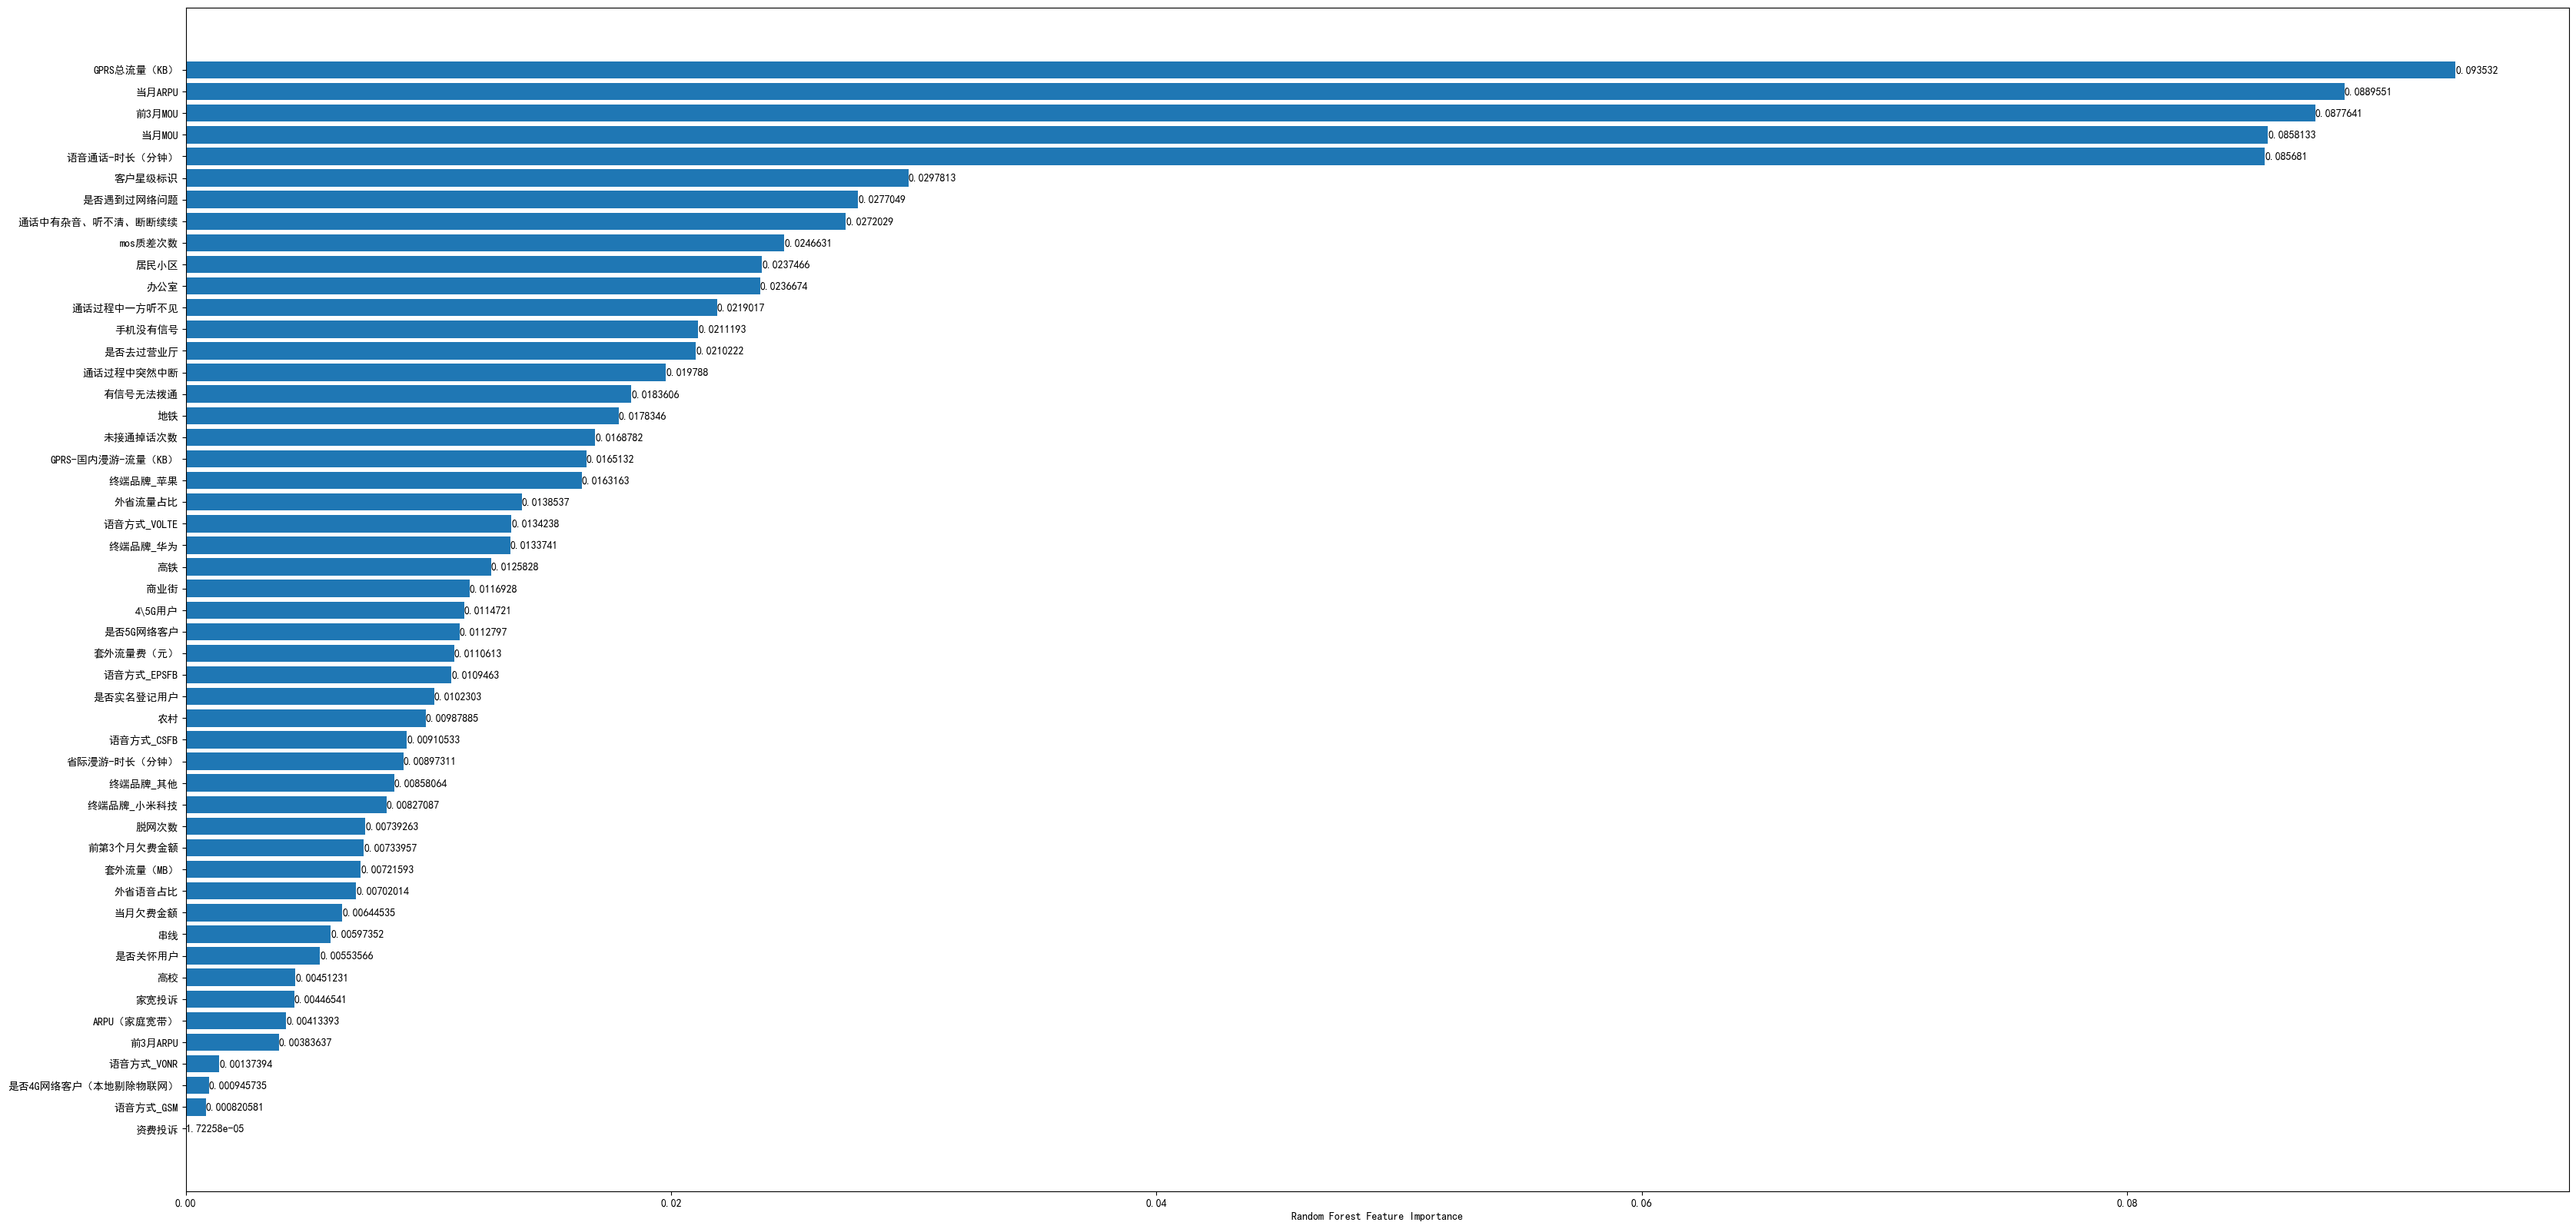

In [24]:
# 画特征重要性排序图
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

In [25]:
# 使用三分项拟合整体满意度
# y = pd.concat([y1,y2,y3],axis=1)
# v_y = pd.concat([v_y1, v_y2, v_y3], axis=1)
# for i in range(4):
#     rfc = RandomForestClassifier(criterion='gini')
#     rfc.fit(y, y0)
#     print('Training Accuracy : ',accuracy_score(y0, rfc.predict(y))*100)
#     print('Validation Accuracy : ',accuracy_score(v_y0, rfc.predict(v_y))*100)

In [26]:
# x --> y1,y2,y3 --> y0
# y_pred = []
# for i in range(1,4):
#     rfc = RandomForestClassifier().fit(x,eval(f'y{i}'))
#     y_pred.append(rfc.predict(v_x))
#     score = accuracy_score(eval(f'v_y{i}'), y_pred[i-1])
#     print('score: ',score)

In [27]:
# y_pred.append(rfc.predict(np.array(y_pred).T))
# accuracy_score(v_y0, y_pred[3])

2. lightGBM

In [28]:
y_vali = y_vali-1
y_train = y_train-1

# lgb-54
train_matrix = lightgbm.Dataset(x_train, y_train)
test_matrix = lightgbm.Dataset(x_vali, y_vali)
params = {
    'objective': 'multiclass',
    'num_class': 10,
    'min_data_in_leaf': 5,
    'num_leaves': 255,
    'matric': 'multi_error',
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'learning_rate': 0.03,
    'seed': 2023
}
num_round = 200
early_stopping_rounds = 100
model = lightgbm.train(
    params,
    train_matrix, num_round
)

y_pred = model.predict(x_vali)

y_pred = [np.argmax(line) for line in y_pred]
accuracy_score(y_vali, y_pred)


[LightGBM] [Warning] Unknown parameter: matric
[LightGBM] [Warning] Unknown parameter: matric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 3799, number of used features: 49
[LightGBM] [Info] Start training from score -3.212055
[LightGBM] [Info] Start training from score -4.841296
[LightGBM] [Info] Start training from score -4.217141
[LightGBM] [Info] Start training from score -4.481293
[LightGBM] [Info] Start training from score -3.455001
[LightGBM] [Info] Start training from score -3.406211
[LightGBM] [Info] Start training from score -3.279649
[LightGBM] [Info] Start training from score -2.286656
[LightGBM] [Info] Start training from score -1.954635
[LightGBM] [Info] Start training from score -0.544464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.5813382443216697

In [29]:
y_vali = y_vali+1
y_train = y_train+1

3. XGBoost

In [30]:
y_vali = y_vali-1
y_train = y_train-1

model = XGBClassifier().fit(x_train, y_train)
y0_pred = model.predict(x_vali)
accuracy_score(y_vali, y0_pred)

0.5549416820135052

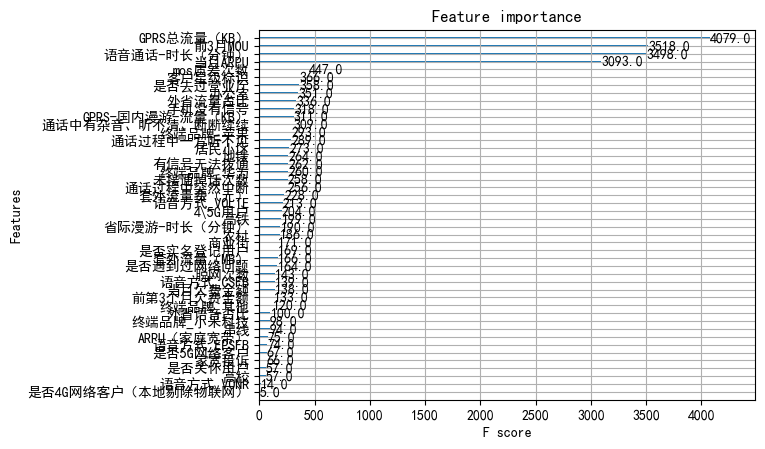

In [31]:
plot_importance(model)
plt.show()

In [32]:
y_vali = y_vali+1
y_train = y_train+1

In [24]:
train_1=train.drop(labels=['前3月MOU','语音通话-时长（分钟）',
'外省流量占比','外省语音占比','省际漫游-时长（分钟）',
'前第3个月欠费金额',
'套外流量费（元）',
'前3月ARPU'],axis=1)


In [25]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_1, target.iloc[:,0],test_size=0.3)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train)))
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali)))
    print('out-of-bagging Accuracy:',rfc.oob_score_)

第0次测试：
Training Accuracy :  1.0
Validation Accuracy :  0.580110497237569
out-of-bagging Accuracy: 0.569097130823901
第1次测试：
Training Accuracy :  1.0
Validation Accuracy :  0.5739717618170657
out-of-bagging Accuracy: 0.5633061331929455
第2次测试：
Training Accuracy :  1.0
Validation Accuracy :  0.5733578882750153
out-of-bagging Accuracy: 0.5669913135035536
第3次测试：
Training Accuracy :  1.0
Validation Accuracy :  0.574585635359116
out-of-bagging Accuracy: 0.5664648591734667


Text(0.5, 0, 'Random Forest Feature Importance')

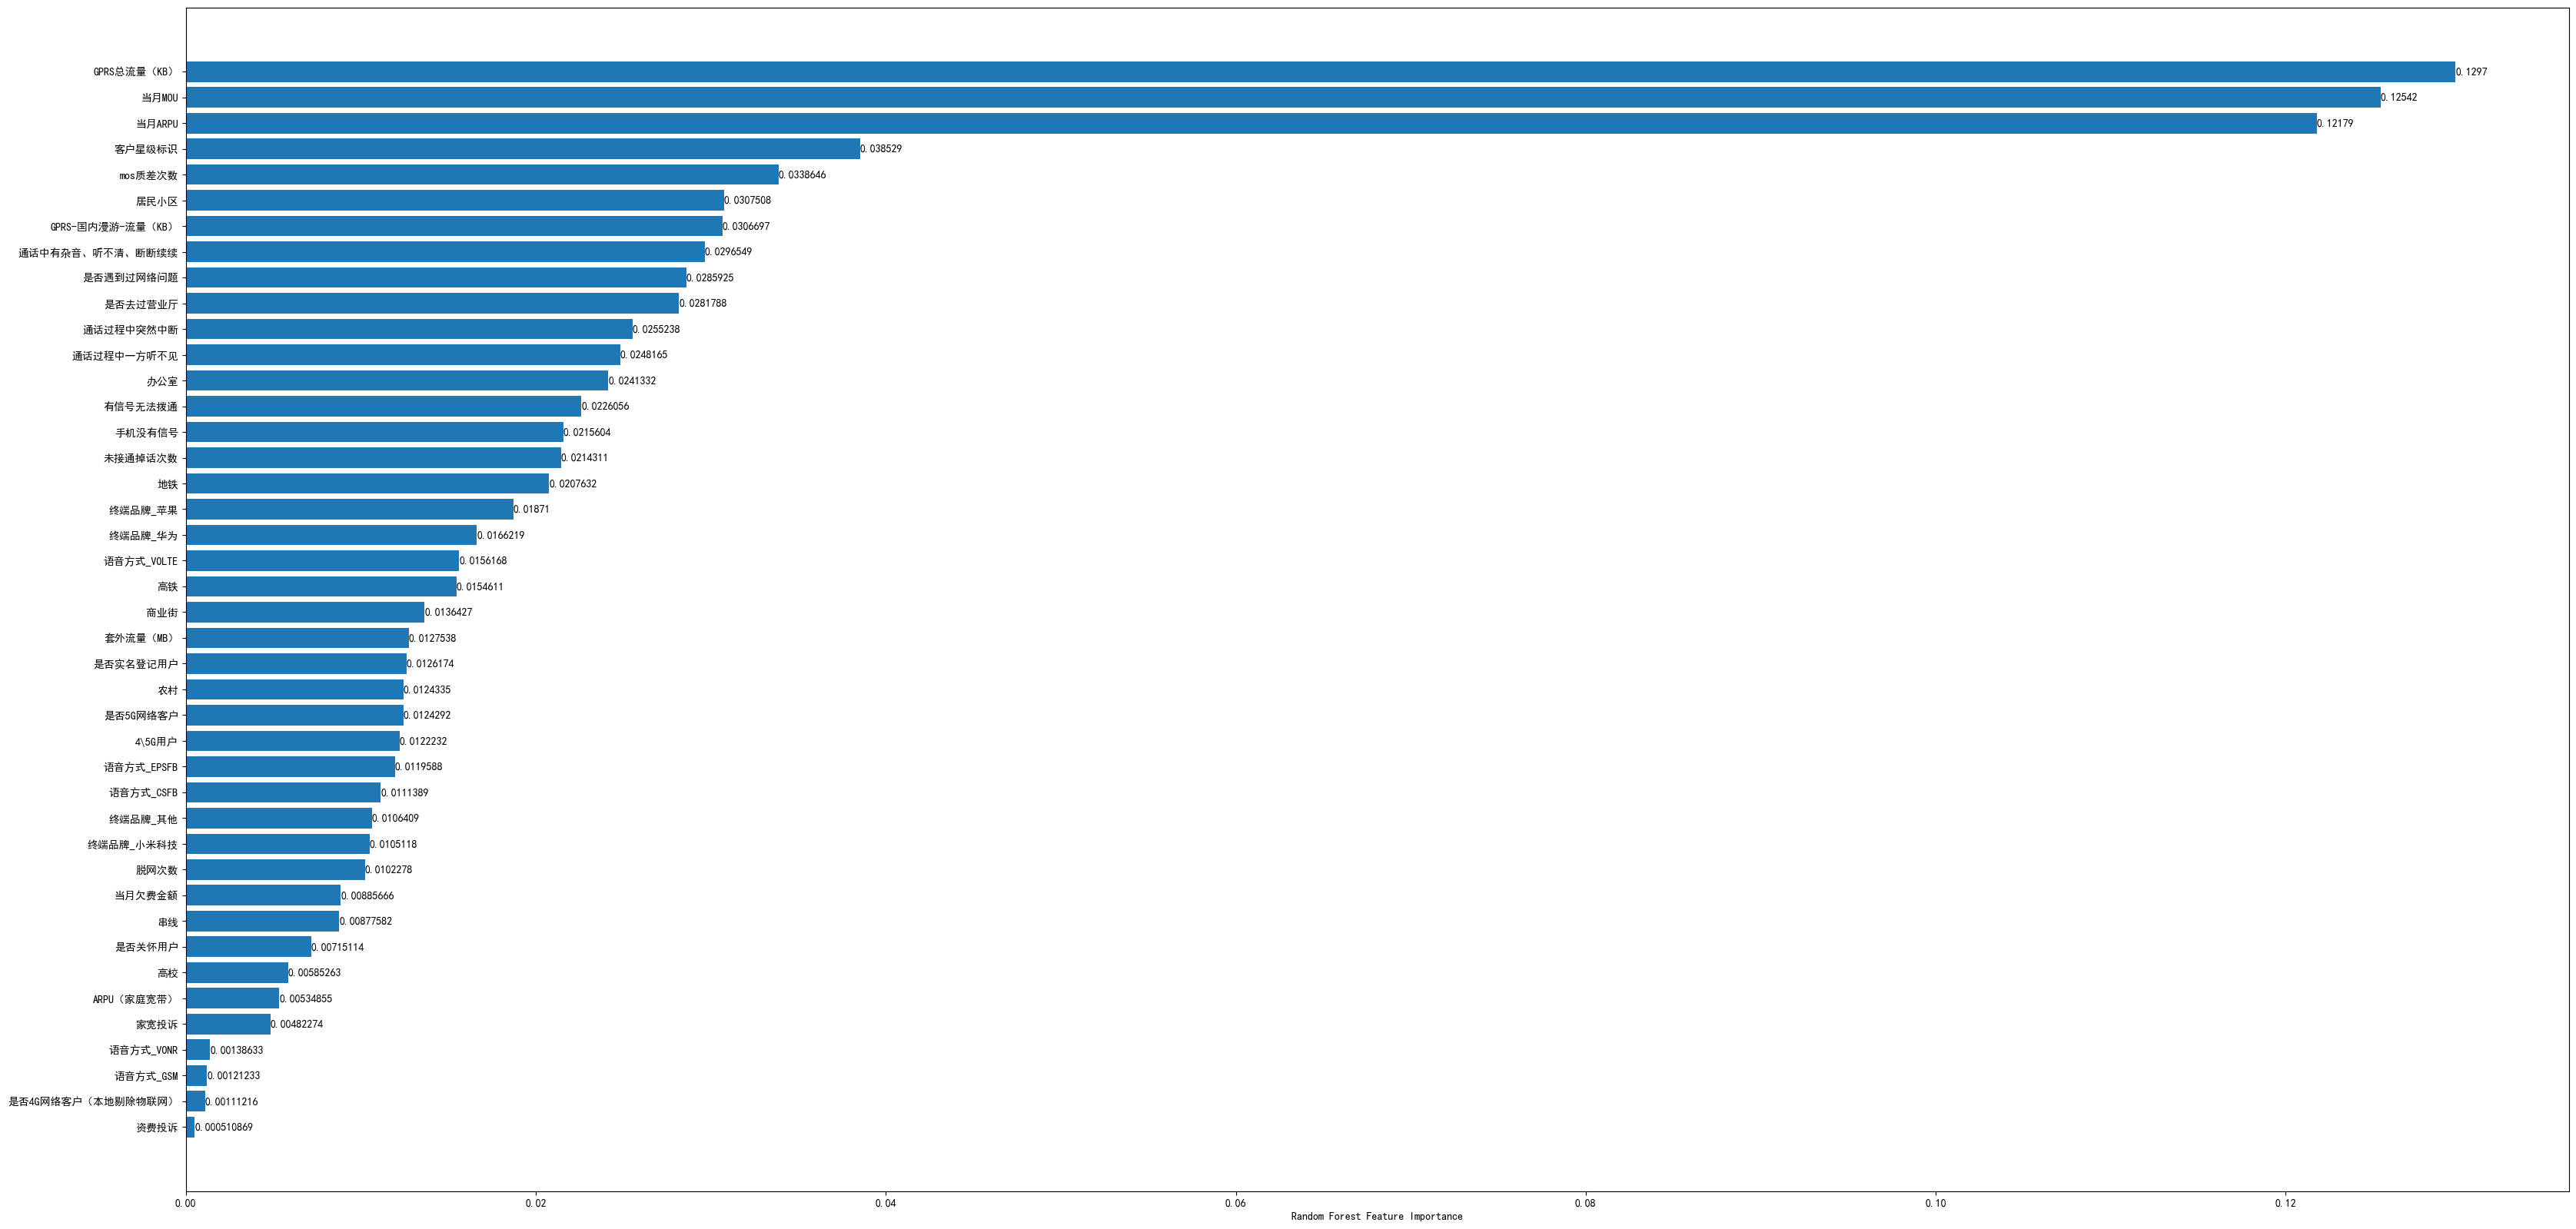

In [41]:
# 画特征重要性排序图
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

In [27]:
import itertools

In [48]:
# def plot_confusion_matrix(cm, classes, normalize=False, title='State transition matrix', cmap=plt.cm.Blues):
    
#     plt.figure()
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)

#     plt.axis("equal")

#     ax = plt.gca()
#     left, right = plt.xlim()
#     ax.spines['left'].set_position(('data', left))
#     ax.spines['right'].set_position(('data', right))
#     for edge_i in ['top', 'bottom', 'right', 'left']:
#         ax.spines[edge_i].set_edgecolor("white")
        

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
#         plt.text(j, i, num,
#                  verticalalignment='center',
#                  horizontalalignment="center",
#                  color="white" if num > thresh else "black")
    
#     plt.ylabel('Self patt')
#     plt.xlabel('Transition patt')
    
#     plt.tight_layout()
#     plt.savefig('method_2.png', transparent=True, dpi=800) 
    
#     plt.show()


# trans_mat = mx

# """method 2"""
# if True:
#     label = ["Patt {}".format(i) for i in range(1, trans_mat.shape[0]+1)]
#     plot_confusion_matrix(trans_mat, label)

In [28]:
# rfc = RandomForestClassifier(oob_score=True).fit(x_train,y_train)
# y_pred = rfc.predict(x_vali)
# mx = confusion_matrix(y_vali, y_pred, labels=None, sample_weight=None)

- 特征工程

1. 训练集测试集对齐

In [31]:
# 将家宽投诉和资费投诉合并为新的变量“是否投诉”，若家宽投诉和资费投诉均为0，则是否投诉等于0，否则等于1.
train['是否投诉']=train['家宽投诉']+train['资费投诉']
train['是否投诉']=train['是否投诉'].apply(lambda x: 0 if x==0 else 1)

In [32]:
# 生成排除线性相关变量后的数据集train_1
train_1=train.drop(labels=['前3月MOU','语音通话-时长（分钟）',
'外省流量占比','外省语音占比','省际漫游-时长（分钟）',
'前第3个月欠费金额',
'套外流量费（元）',
'前3月ARPU',
'家宽投诉','资费投诉',],axis=1)
# 排除训练集中存在，但测试集中不存在的变量字段
train_1 = train_1.drop(['ARPU（家庭宽带）','当月欠费金额','是否去过营业厅','是否实名登记用户',
'语音方式_CSFB', '语音方式_EPSFB', '语音方式_GSM', '语音方式_VOLTE', '语音方式_VONR'], axis=1)

In [33]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_1, target.iloc[:,0],test_size=0.3)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)


第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  56.96746470227133
out-of-bagging Accuracy: 56.40958146880758
第1次测试：
Training Accuracy :  99.97367728349566
Validation Accuracy :  55.310006138735424
out-of-bagging Accuracy: 56.77809949986838
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  56.29220380601596
out-of-bagging Accuracy: 56.51487233482495
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  56.599140577041126
out-of-bagging Accuracy: 56.172677020268495


Text(0.5, 0, 'Random Forest Feature Importance')

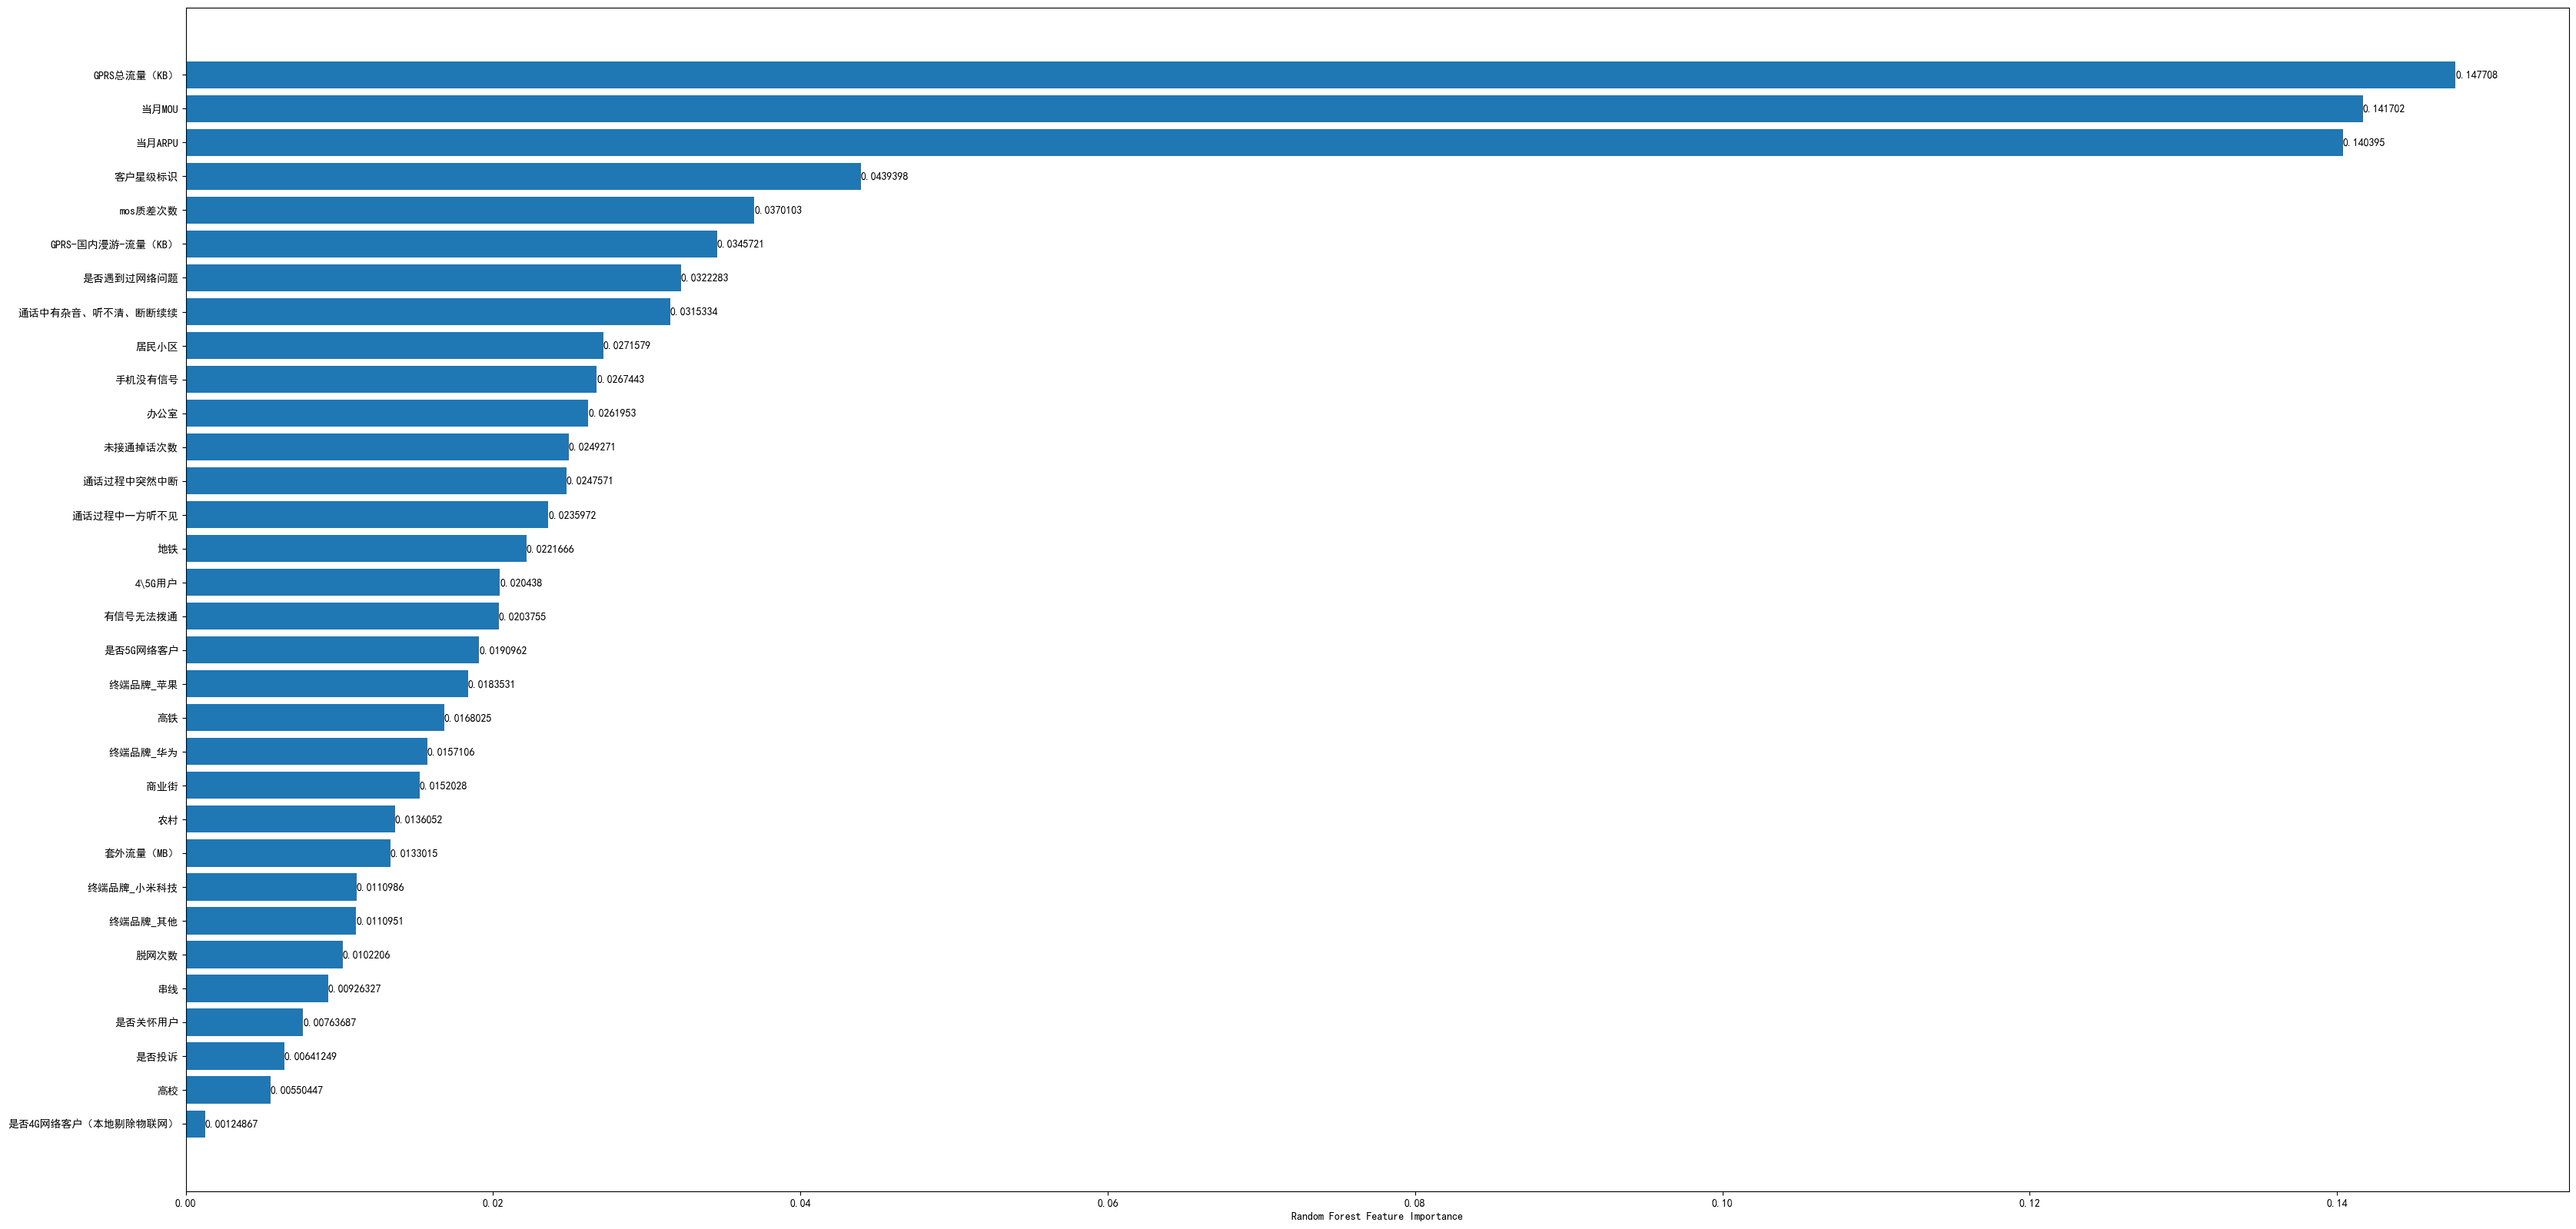

In [34]:
# 画特征重要性排序图
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

2. 特征衍生

In [35]:
train_2 = train_1.copy()

In [36]:
# 构建三大分项特征
train_2['网络覆盖范围问题']=train_2['居民小区']+train_2['办公室']+train_2['高校']+train_2['商业街']+train_2['地铁']+train_2['农村']+train_2['高铁']
train_2['信号强度问题']=train_2['有信号无法拨通']+train_2['手机没有信号']+train_2['脱网次数']
train_2['通话清晰度问题']=train_2['通话中有杂音、听不清、断断续续']+train_2['通话过程中一方听不见']+train_2['mos质差次数']
train_2['通话稳定性问题']=train_2['通话过程中突然中断']+train_2['串线']+train_2['未接通掉话次数']

In [37]:
# 构建客户特征
colname_sub = ['4\\5G用户','是否关怀用户','是否4G网络客户（本地剔除物联网）','是否5G网络客户','客户星级标识','终端品牌_其他', '终端品牌_华为',
'终端品牌_小米科技', '终端品牌_苹果', '是否投诉']
numcols_sub = ['当月ARPU','套外流量（MB）','当月MOU', 'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']
aggs = {}
for col in numcols_sub:
    aggs[col] = ['min','mean','max','std']
aggs

{'当月ARPU': ['min', 'mean', 'max', 'std'],
 '套外流量（MB）': ['min', 'mean', 'max', 'std'],
 '当月MOU': ['min', 'mean', 'max', 'std'],
 'GPRS总流量（KB）': ['min', 'mean', 'max', 'std'],
 'GPRS-国内漫游-流量（KB）': ['min', 'mean', 'max', 'std']}

In [38]:
# 添加新特征
for cate in colname_sub:
    cols_new = []
    cols_new.append(cate)
    for key in aggs.keys():
        cols_new.extend([key + '_' + cate + '_' + stat for stat in aggs[key]])

    new_feature = train_2.groupby(cate).agg(aggs).reset_index()
    new_feature.columns = cols_new
    train_2 = pd.merge(train_2, new_feature, how='left', on=cate)

In [39]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,0],test_size=0.3,random_state=0)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)


第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  54.38919582565992
out-of-bagging Accuracy: 55.751513556198994
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.00306936771025
out-of-bagging Accuracy: 55.83048170571203
第2次测试：
Training Accuracy :  99.97367728349566
Validation Accuracy :  54.32780847145487
out-of-bagging Accuracy: 55.988418004738094
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.494168201350526
out-of-bagging Accuracy: 56.51487233482495


Text(0.5, 0, 'Random Forest Feature Importance')

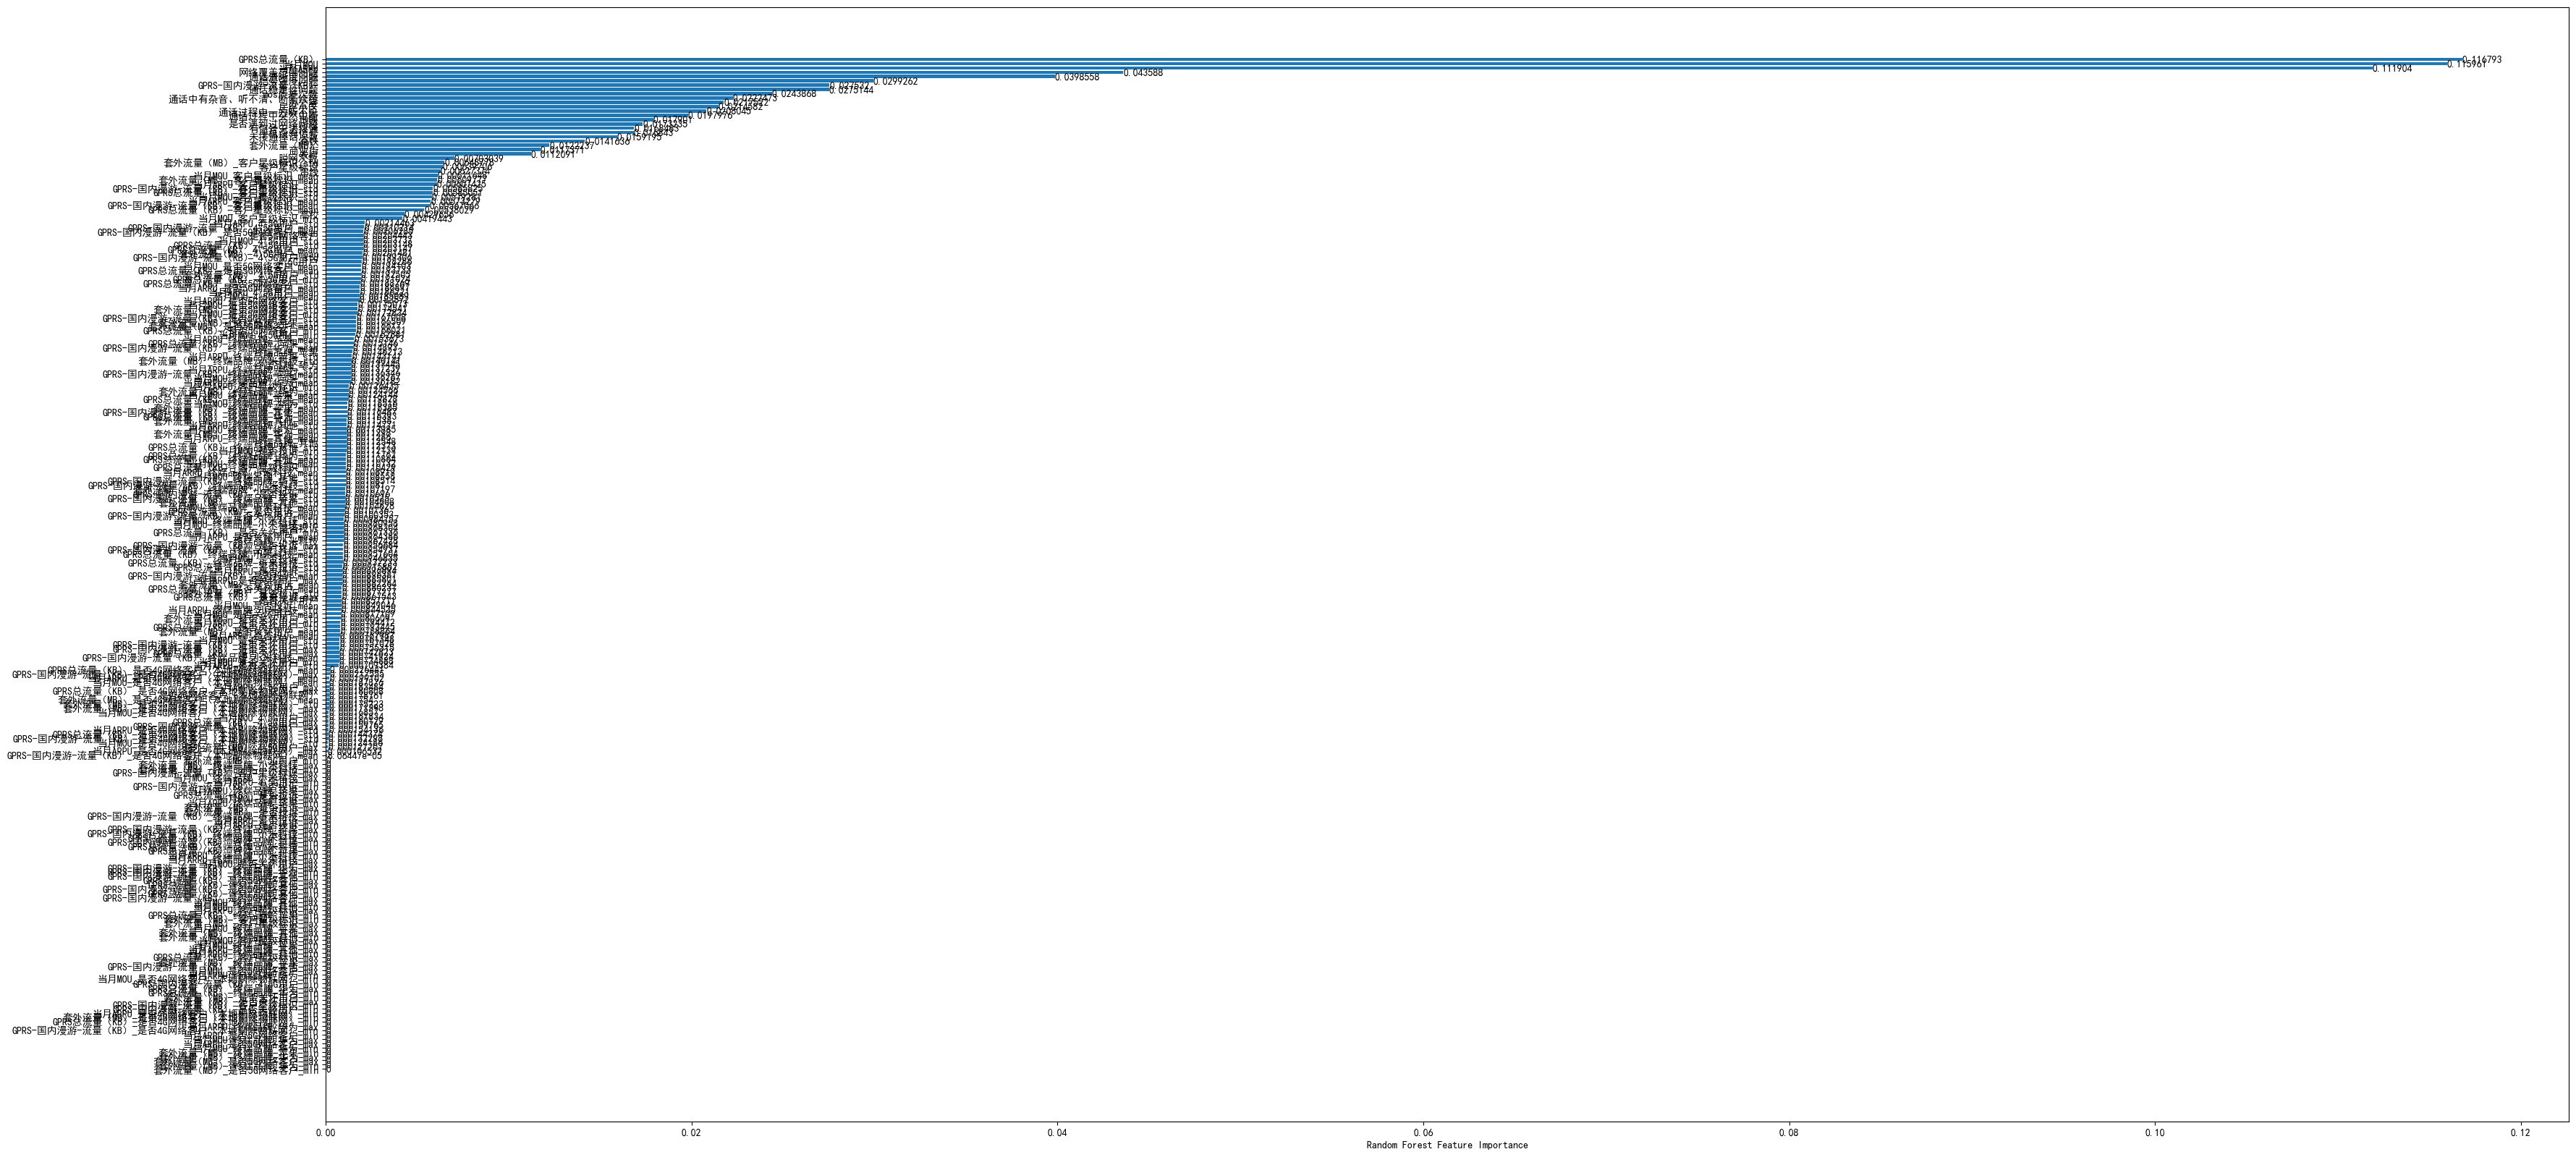

In [40]:
# 画特征重要性排序图
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

In [41]:
# 剔除重要性小于0.003的变量
sorted_idx = rfc.feature_importances_.argsort()
num = rfc.feature_importances_[sorted_idx]
name = rfc.feature_names_in_[sorted_idx]

sel = {}
drop_list = []
for i,j in zip(name,num):
    if j>0.003:
        sel[i] = j
    else:
        drop_list.append(i)

train_2 = train_2.drop(drop_list,axis=1)


In [42]:
train_2.shape

(5428, 38)

In [43]:
# 切分训练和验证集
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,0],test_size=0.3,random_state=0)
for i in range(4):
    rfc = RandomForestClassifier(oob_score=True,random_state=0)
    rfc.fit(x_train, y_train)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
    print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

第0次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.98526703499079
out-of-bagging Accuracy: 55.46196367465123
第1次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.98526703499079
out-of-bagging Accuracy: 55.46196367465123
第2次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.98526703499079
out-of-bagging Accuracy: 55.46196367465123
第3次测试：
Training Accuracy :  100.0
Validation Accuracy :  55.98526703499079
out-of-bagging Accuracy: 55.46196367465123


In [44]:
# RFE剔除
rfc = RandomForestClassifier(oob_score=True)
rfe = RFE(estimator=rfc)
rfe.fit(x_train, y_train)
drop_list = rfe.feature_names_in_[~rfe.get_support()]
train_2 = train_2.drop(drop_list,axis=1)
train_2.shape

(5428, 19)

In [45]:
# # 切分训练和验证集
# x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,0],test_size=0.3,random_state=0)
# for i in range(4):
#     rfc = RandomForestClassifier(oob_score=True)
#     rfc.fit(x_train, y_train)
#     print(f'第{i}次测试：')
#     print('Training Accuracy : ',accuracy_score(y_train, rfc.predict(x_train))*100)
#     print('Validation Accuracy : ',accuracy_score(y_vali, rfc.predict(x_vali))*100)
#     print('out-of-bagging Accuracy:',rfc.oob_score_*100)

In [46]:
train_2.columns.values

array(['是否遇到过网络问题', '居民小区', '办公室', '地铁', '通话中有杂音、听不清、断断续续', '通话过程中一方听不见',
       'mos质差次数', '未接通掉话次数', '当月ARPU', '当月MOU', 'GPRS总流量（KB）',
       'GPRS-国内漫游-流量（KB）', '网络覆盖范围问题', '信号强度问题', '通话清晰度问题', '通话稳定性问题',
       '套外流量（MB）_客户星级标识_mean', '套外流量（MB）_客户星级标识_std', '当月MOU_客户星级标识_mean'],
      dtype=object)

- 参数优化

In [47]:
# # 网格调参
x_train,x_vali,y_train,y_vali = train_test_split(train_2, target.iloc[:,0],test_size=0.3,random_state=0)

# params = {
#     'criterion' : ["gini",'entropy'],
#     'min_samples_leaf': range(1,11,3),
#     'min_samples_split' : range(1,11,3),
#     'max_depth': range(5,16,5),
#     'max_samples': ['None',0.5,0.7,0.9],
#     'max_features': ["sqrt",'log2',2,4,6],
#     'n_estimators': range(10,160,70)
    
# }

# rfc_0 = RandomForestClassifier(random_state=0)
# grid_rfc_0 = GridSearchCV(rfc_0, params, n_jobs=-1)
# grid_rfc_0.fit(x_train, y_train)

In [156]:
grid_rfc_0.best_score_

0.5922609389085361

In [157]:
grid_rfc_0.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=2,
                       max_samples=0.9, min_samples_leaf=7, min_samples_split=4,
                       n_estimators=150, random_state=0)

- 预测结果（语音整体满意度）

In [178]:
# 对训练数据按照相同方法生成特征，然后用调整好之后的模型进行预测
# 构建三大分项特征
test['网络覆盖范围问题']=test['居民小区']+test['办公室']+test['高校']+test['商业街']+test['地铁']+test['农村']+test['高铁']
test['信号强度问题']=test['有信号无法拨通']+test['手机没有信号']+test['脱网次数']
test['通话清晰度问题']=test['通话中有杂音、听不清、断断续续']+test['通话过程中一方听不见']+test['mos质差次数']
test['通话稳定性问题']=test['通话过程中突然中断']+test['串线']+test['未接通掉话次数']

In [179]:
# 构建客户特征
colname_sub = ['4\\5G用户','是否关怀用户','是否4G网络客户（本地剔除物联网）','是否5G网络客户','客户星级标识','终端品牌_其他', '终端品牌_华为',
'终端品牌_小米科技', '终端品牌_苹果', '是否投诉']
numcols_sub = ['当月ARPU','套外流量（MB）','当月MOU', 'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']
aggs = {}
for col in numcols_sub:
    aggs[col] = ['min','mean','max','std']
# 添加新特征
for cate in colname_sub:
    cols_new = []
    cols_new.append(cate)
    for key in aggs.keys():
        cols_new.extend([key + '_' + cate + '_' + stat for stat in aggs[key]])

    new_feature = test.groupby(cate).agg(aggs).reset_index()
    new_feature.columns = cols_new
    test = pd.merge(test, new_feature, how='left', on=cate)

In [180]:
# 删除无用特征并预测语音整体满意度
useless_cols = set(test.columns.values)-set(train_2.columns.values)
test = test.drop(useless_cols, axis=1)
result = grid_rfc_0.predict(test)

array([10, 10, 10, ..., 10, 10, 10], dtype=int64)

In [192]:
np.savetxt('语音整体满意度预测数据.csv', result, delimiter='\n', encoding='utf-8',fmt='%d')

In [49]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=15, max_features=2,
                       max_samples=0.9, min_samples_leaf=7, min_samples_split=4,
                       n_estimators=150, random_state=0).fit(x_train, y_train)
y_pred = rfc.predict(x_vali)
mx = confusion_matrix(y_vali, y_pred, labels=None, sample_weight=None)

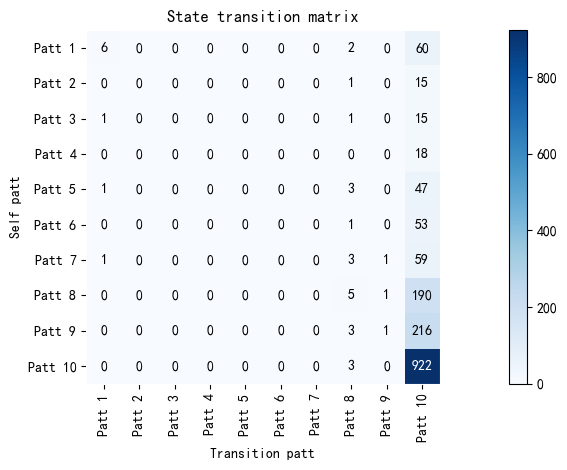

In [50]:
def plot_confusion_matrix(cm, classes, normalize=False, title='State transition matrix', cmap=plt.cm.Blues):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.axis("equal")

    ax = plt.gca()
    left, right = plt.xlim()
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")
        

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if num > thresh else "black")
    
    plt.ylabel('Self patt')
    plt.xlabel('Transition patt')
    
    plt.tight_layout()
    plt.savefig('method_2.png', transparent=True, dpi=800) 
    
    plt.show()


trans_mat = mx

"""method 2"""
if True:
    label = ["Patt {}".format(i) for i in range(1, trans_mat.shape[0]+1)]
    plot_confusion_matrix(trans_mat, label)